In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score

# Device setup (not required for ExtraTreesClassifier but kept for compatibility)
device = "cpu"

# Label mapping
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Data directory and CSV path
csv_path = "/content/drive/MyDrive/xrd_model_training/structure_info.csv"  # Replace with actual path
!unzip /content/drive/MyDrive/xrd_model_training/output_data.zip -d /content/drive/MyDrive/xrd_model_training
data_dir = "/content/drive/MyDrive/xrd_model_training/output_data"  # Directory with .npz files
df = pd.read_csv(csv_path)

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2010029_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9005109_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9001581_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/7204651_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9015097_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/9017878_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2002958_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/4336921_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/4344119_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/2106754_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_model_training/output_data/15

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Preprocessing function
def load_xrd_data(file_list, data_dir):
    X, y = [], []
    for file_name, label in file_list:
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)

        # Load intensity data
        if os.path.exists(file_path):
            data = np.load(file_path)
            x = data['y_convolved'].astype(np.float32)  # Use intensity data
            X.append(x)
            y.append(label_map[label])
    return np.array(X), np.array(y)

# Split the data into train, test, and validation sets
split_info = {
    "tetragonal": (1000, 1000, 100),
    "orthorhombic": (1000, 1000, 100),
    "trigonal": (1000, 1000, 100),
    "cubic": (1000, 1000, 100),
    "triclinic": (1000, 1000, 100),
    "monoclinic": (1000, 1000, 100),
    "hexagonal": (100, 100, 5)
}

In [5]:
train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split into training, testing, and validation sets
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, _ = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

In [6]:
# Load the datasets
X_train, y_train = load_xrd_data(train_list, data_dir)
X_test, y_test = load_xrd_data(test_list, data_dir)
X_val, y_val = load_xrd_data(val_list, data_dir)

# Flatten the feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)


In [13]:
# Train the ExtraTreesClassifier

clf = ExtraTreesClassifier(n_estimators=500,
                            max_depth=30,
                            max_features=7,
                            n_jobs=-1,
                            random_state=42,
                            warm_start=False)

clf.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=30, max_features=7, n_estimators=500, n_jobs=-1,
                     random_state=42)

In [14]:
# Validate the model
y_val_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Validation Accuracy: 0.32066115702479336
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.16      0.19       100
           1       0.28      0.18      0.22       100
           2       0.15      0.11      0.13       100
           3       0.35      0.75      0.48       100
           4       0.42      0.55      0.47       100
           5       0.33      0.19      0.24       100
           6       0.00      0.00      0.00         5

    accuracy                           0.32       605
   macro avg       0.25      0.28      0.25       605
weighted avg       0.29      0.32      0.29       605



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.32098360655737707
Test Classification Report:
               precision    recall  f1-score   support

           0       0.26      0.19      0.22      1000
           1       0.23      0.12      0.15      1000
           2       0.24      0.18      0.21      1000
           3       0.35      0.69      0.46      1000
           4       0.41      0.57      0.47      1000
           5       0.29      0.21      0.24      1000
           6       0.00      0.00      0.00       100

    accuracy                           0.32      6100
   macro avg       0.25      0.28      0.25      6100
weighted avg       0.29      0.32      0.29      6100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 800x800 with 0 Axes>

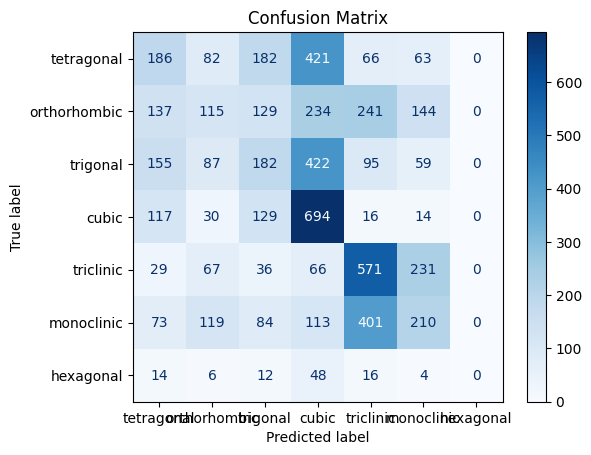

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix for the test set
cm = confusion_matrix(y_test, y_test_pred, normalize='true')

# Create a display for the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [6]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Label map for the classification task
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Function to extract features from XRD data
def extract_features_with_all_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        peak_positions = np.pad(peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        peak_intensities = np.pad(peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
        widths = np.zeros(max_peaks)
    else:
        # Compute Full Width at Half Maximum (FWHM) of each peak
        widths = peak_widths(intensity, peaks)[0]  # widths of the peaks

    # Compute global statistics
    avg_peak_intensity = np.mean(peak_intensities) if num_detected_peaks > 0 else 0
    std_peak_intensity = np.std(peak_intensities) if num_detected_peaks > 0 else 0
    mean_fwhm = np.mean(widths) if num_detected_peaks > 0 else 0
    std_fwhm = np.std(widths) if num_detected_peaks > 0 else 0

    # Create feature vector with peak positions, intensities, and FWHM, followed by global statistics
    feature_vector = np.concatenate([
        peak_positions[:max_peaks],  # First 10 peaks' positions
        peak_intensities[:max_peaks],  # First 10 peaks' intensities
        #widths[:max_peaks],  # First 10 peaks' FWHM values
        #[num_detected_peaks, avg_peak_intensity, std_peak_intensity]
        [num_detected_peaks]
    ])

    return feature_vector

def process_data_with_all_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with all peaks and statistics
        feature = extract_features_with_all_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)






In [50]:
def extract_features_with_sorted_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, properties = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Sort peaks by intensity in descending order
    sorted_indices = np.argsort(peak_intensities)[::-1]
    sorted_peak_positions = peak_positions[sorted_indices]
    sorted_peak_intensities = peak_intensities[sorted_indices]

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        sorted_peak_positions = np.pad(sorted_peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        sorted_peak_intensities = np.pad(sorted_peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
    else:
        # Limit to the top `max_peaks`
        sorted_peak_positions = sorted_peak_positions[:max_peaks]
        sorted_peak_intensities = sorted_peak_intensities[:max_peaks]

    # Create feature vector with sorted peak positions and intensities
    feature_vector = np.concatenate([
        sorted_peak_positions,  # Sorted peak positions
        sorted_peak_intensities  # Sorted peak intensities
    ,[num_detected_peaks]])

    return feature_vector


def process_data_with_sorted_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with sorted peaks
        feature = extract_features_with_sorted_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [70]:
def extract_features_with_top_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Sort peaks by intensity in descending order
    sorted_indices = np.argsort(peak_intensities)[::-1]
    sorted_peak_positions = peak_positions[sorted_indices]
    sorted_peak_intensities = peak_intensities[sorted_indices]

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        sorted_peak_positions = np.pad(sorted_peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        sorted_peak_intensities = np.pad(sorted_peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
    else:
        # Limit to the top `max_peaks`
        sorted_peak_positions = sorted_peak_positions[:max_peaks]
        sorted_peak_intensities = sorted_peak_intensities[:max_peaks]

    # Create feature vector with top peak positions and intensities
    feature_vector = np.concatenate([
        sorted_peak_positions,  # Top `max_peaks` sorted peak positions
        sorted_peak_intensities  # Top `max_peaks` sorted peak intensities
    ])

    return feature_vector

def process_data_with_top_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with top peaks
        feature = extract_features_with_top_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [7]:
# Split data based on split_info
split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3500, 500, 300),
    "trigonal": (2000, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (2000, 300, 10),
    "monoclinic": (3000, 500, 300),
    "hexagonal": (100, 10, 5)
}

train_list, test_list, val_list = [], [], []
for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split the dataset
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)




In [11]:
# Define maximum number of peaks for padding
max_peaks = 15

# Process datasets to extract features and labels
X_train, y_train = process_data_with_all_peaks(train_list, data_dir, max_peaks)
X_test, y_test = process_data_with_all_peaks(test_list, data_dir, max_peaks)
X_val, y_val = process_data_with_all_peaks(val_list, data_dir, max_peaks)



In [91]:
print(X_train[0])

[17.36145401 23.96223068 24.65231133 27.63266182 29.74291039 33.10330582
 35.14354706 38.30391693 41.71432114 42.98447037  0.05396441  1.03090763
  0.68766594  0.05283605  0.26896563  0.39668053  0.68429852  0.05672311
  0.21172881  0.58514643 31.        ]


In [12]:
# Train the ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=500,
                            max_depth=30,
                            max_features=7,
                            n_jobs=-1,
                            random_state=42,
                            warm_start=False)
clf.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=30, max_features=7, n_estimators=500, n_jobs=-1,
                     random_state=42)

Test Accuracy: 0.6751


<Figure size 800x800 with 0 Axes>

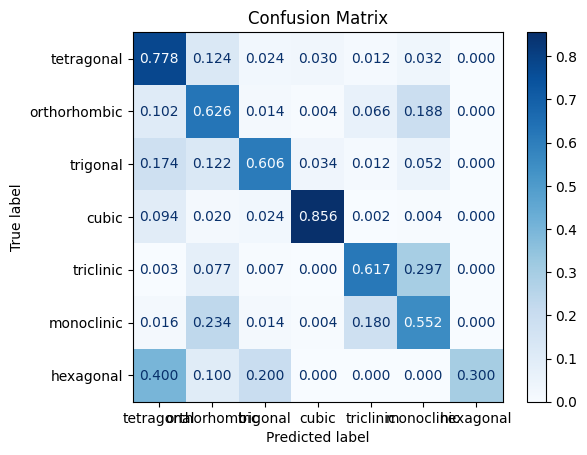

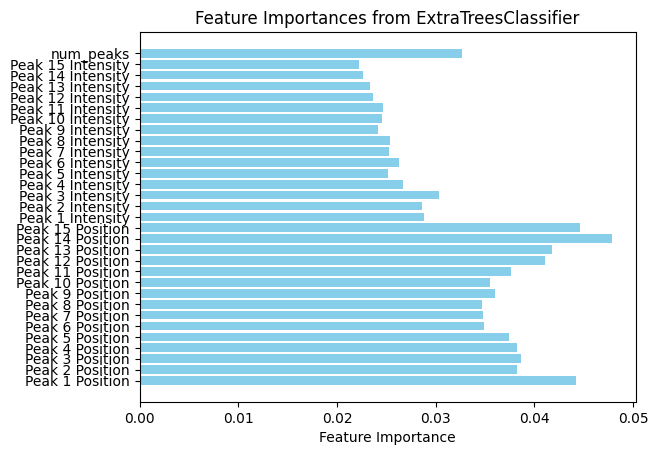

In [13]:
# Evaluate the model
y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='.3f')
plt.title("Confusion Matrix")
plt.show()

feature_names = [f"Peak {i+1} Position" for i in range(max_peaks)] + \
                [f"Peak {i+1} Intensity" for i in range(max_peaks)] + \
                ["num_peaks"]
                #["num_peaks", "avg_peak_intensity", "std_peak_intensity"]


importances = clf.feature_importances_

# Ensure that the number of features matches the number of feature names
assert len(importances) == len(feature_names), "Mismatch between the number of features and feature names"

plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importances from ExtraTreesClassifier")
plt.show()

In [31]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_peaks(intensity, angles, title="XRD Pattern with Peaks"):
    # Find peaks
    peaks, _ = find_peaks(intensity, height=0.1 * np.max(intensity))  # Adjust height threshold

    # Plot XRD pattern
    plt.figure(figsize=(10, 6))
    plt.plot(angles, intensity, label="XRD Pattern")

    # Highlight peaks
    plt.scatter(angles[peaks], intensity[peaks], color='red', label="Detected Peaks", zorder=3)
    plt.xlabel("Angle (2θ)")
    plt.ylabel("Intensity")
    plt.title(title)
    plt.legend()
    plt.show()


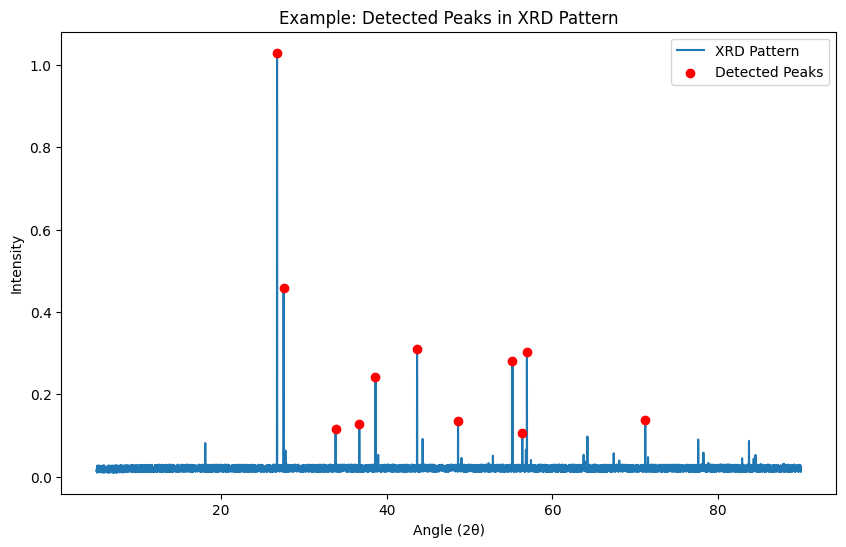

In [32]:
# Example: Plot the first sample from the training set
example_file, _ = train_list[0]
example_file = example_file.replace('.cif', '_convolved.npz')
example_path = os.path.join(data_dir, example_file)

# Load the data
example_data = np.load(example_path)
example_intensity = example_data['y_convolved']
example_angles = example_data['x_fine']

# Plot the peaks
plot_peaks(example_intensity, example_angles, title="Example: Detected Peaks in XRD Pattern")


KeyboardInterrupt: 

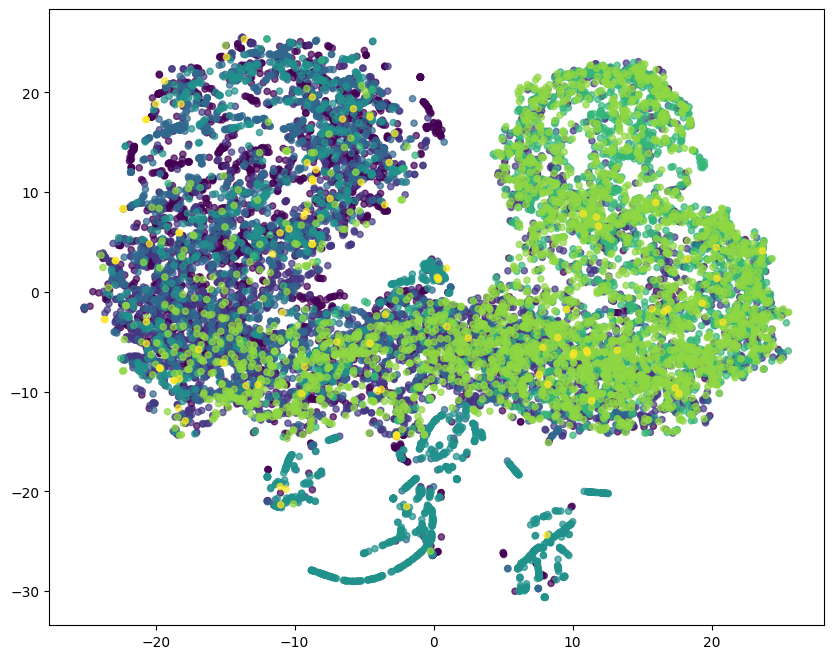

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Apply t-SNE to the training set
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Plot the t-SNE projection
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', s=20, alpha=0.7
)

def visualize_tsne_3d(X, y, label_map):
    tsne = TSNE(n_components=3, random_state=42)
    X_embedded = tsne.fit_transform(X)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap='tab10', alpha=0.7)

    ax.set_title("3D t-SNE Projection of XRD Data")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")

    legend_labels = {v: k for k, v in label_map.items()}
    colorbar = fig.colorbar(scatter, ax=ax, ticks=range(len(label_map)))
    colorbar.set_ticklabels([legend_labels[i] for i in range(len(label_map))])

    plt.show()

visualize_tsne_3d(X_train, y_train, label_map)




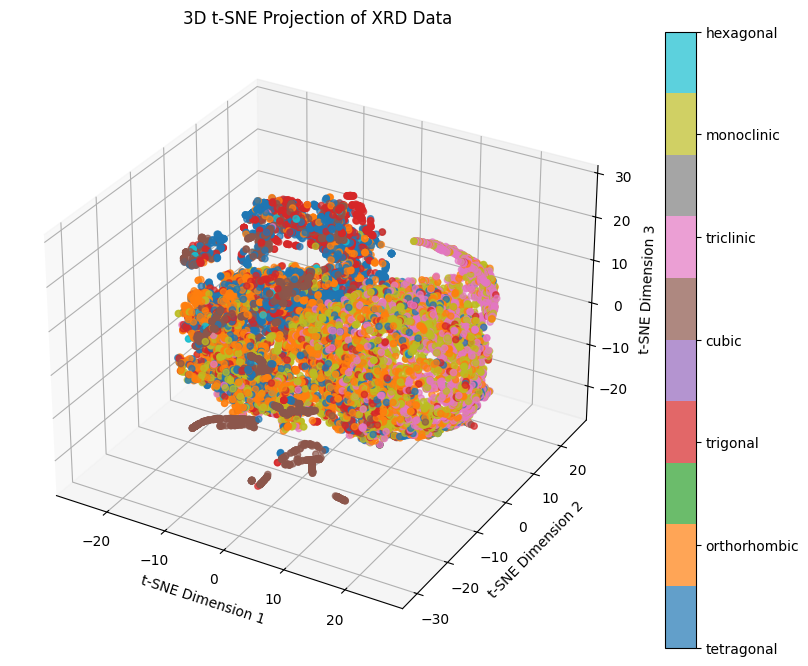

In [17]:
def visualize_tsne_3d(X, y, label_map):
    tsne = TSNE(n_components=3, random_state=42)
    X_embedded = X

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap='tab10', alpha=0.7)

    ax.set_title("3D t-SNE Projection of XRD Data")
    ax.set_xlabel("t-SNE Dimension 1")
    ax.set_ylabel("t-SNE Dimension 2")
    ax.set_zlabel("t-SNE Dimension 3")

    legend_labels = {v: k for k, v in label_map.items()}
    colorbar = fig.colorbar(scatter, ax=ax, ticks=range(len(label_map)))
    colorbar.set_ticklabels([legend_labels[i] for i in range(len(label_map))])

    plt.show()

visualize_tsne_3d(X_tsne, y_train, label_map)

In [ ]:
plt.colorbar(scatter, label='Class')
plt.title("t-SNE Projection of Training Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()